In [5]:

%matplotlib inline

import os
import numpy as np

import gym
import neat
import cv2

import utils.PyPlotReporter
import utils.PyPlotReporter
import utils.CSVReporter
from utils.EnvEvaluator import EnvEvaluator
from utils.Atari import CONTROLLER_TO_ACTION,CONTROLLER_TO_ACTION_SHORT, CONTROLLER_TO_ACTION_FORCE

In [6]:

def ship_attention(obs):
    att = np.zeros(obs.shape)
    att[15,:] = obs[15, :]
    return att

def crop_center(img, pos, size):
    pos, size = np.array(pos), np.array(size)

    a = pos - size//2
    x = a + size
    b = np.maximum(a, 0)
    y = np.minimum(x, img.shape)
    c = b - a
    z = size - (x - y)

    out = np.zeros(size)
    out[c[0]:z[0],c[1]:z[1]] = img[b[0]:y[0], b[1]:y[1]]
    return out 

In [7]:
resize = (16, 21)
att_size = (9, 9)

class AttentionEnvEvaluator(EnvEvaluator):
    def make_net(self, genome, config): 
        return neat.nn.FeedForwardNetwork.create(genome, config)
        
    def activate_net(self, net, observation): 
        ship = np.all((observation == [232,232,74]), axis=-1).astype(np.float32)
        ship = cv2.resize(ship,dsize=resize, interpolation=cv2.INTER_AREA)
        att = ship_attention(ship)
        att_pos = np.unravel_index(np.argmax(att), att.shape)
        
        g1 = np.all((observation == [110, 156, 66]), axis=-1)
        g2 = np.all((observation == [53, 95, 24]), axis=-1)
        grass = np.logical_or(g1, g2).astype(np.float32)
        grass = cv2.resize(grass,dsize=resize, interpolation=cv2.INTER_AREA)
        att_grass = crop_center(grass, att_pos, att_size)   
        
        river = 1-np.all((observation == [45,50,184]), axis=-1).astype(np.float32)
        river = cv2.resize(river,dsize=resize, interpolation=cv2.INTER_AREA)
        att_river = crop_center(river, att_pos, att_size)   
        
        input_ =  np.concatenate((att_grass.flatten(),  att_river.flatten()))
        out = tuple(np.array(net.activate(input_)) > 0.5)
        action = CONTROLLER_TO_ACTION_FORCE[out]
        
        return action 

evaluator = AttentionEnvEvaluator("Riverraid-v0", 5000, n_workers=8, n_batches=1, seed=[1111])

In [10]:
config_path = "./configs/neatattention.cfg" 

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)


pop = neat.Population(config)
pop.add_reporter(utils.CSVReporter.CSVReporter("saves/neat_prog.csv"))
pop.add_reporter(neat.Checkpointer(1, None, "saves/cp_neat_rr"))
pop.add_reporter(utils.PyPlotReporter.PyPlotReporter())



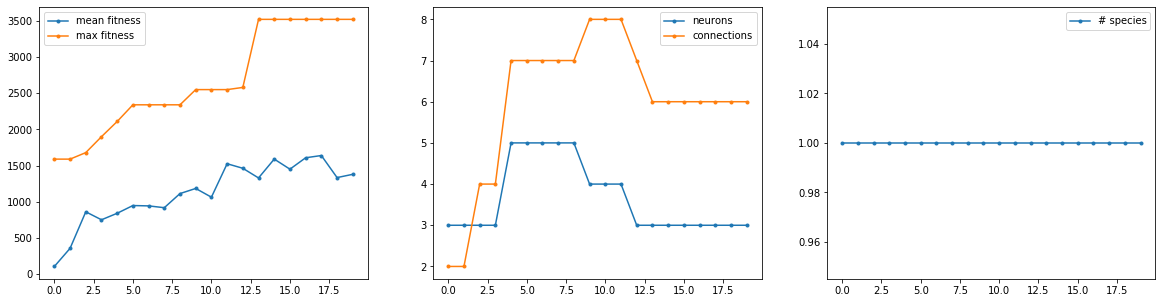

Saving checkpoint to saves/cp_neat_rr19


In [13]:

gnome = pop.run(evaluator.eval_all_genomes, 10)

In [ ]:
import utils.TrainingHelper

utils.TrainingHelper.train_continuously(evaluator, config, max_runs=100, location='./saves2/')

In [ ]:
evaluator.create_video(evaluator,gnome, config, fps=60, fout="f.mp4")